In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

In [10]:
# 2 painters simple convnet

In [11]:
def create_simpleconvnet():
    data_augmentation = keras.Sequential([
        layers.RandomCrop(500, 400),
        layers.RandomZoom(0.2),
        layers.RandomRotation(0.1)
    ])
    
    inputs = keras.Input(shape=(412, 550, 3))
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)    
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss="categorical_crossentropy",optimizer='adam', metrics=["accuracy"])

    model.summary()
    
    return model

In [12]:
model = create_simpleconvnet()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 412, 550, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 500, 400, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 500, 400, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 498, 398, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 249, 199, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 247, 197, 64)      18496     
                                                           

In [13]:
#mix arrays per n elements

def mix(elements1:[], elements2:[], n=5):
    objects_set = []
    labels_set = []
    i = 0
    while i < len(elements1) and i < len(elements2):
            objects_set.append(np.reshape(elements1[i], (412, 550, 3)))
            labels_set.append([1, 0])
    
            objects_set.append(np.reshape(elements2[i], (412, 550, 3)))
            labels_set.append([0, 1])
            
            i+=1
            
    return np.array(objects_set), np.array(labels_set)
    

Epoch 1/30
3/3 [==============================] - 15s 5s/step - loss: 1.2998 - accuracy: 0.5235 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 2/30
3/3 [==============================] - 13s 5s/step - loss: 0.6863 - accuracy: 0.5588 - val_loss: 0.6949 - val_accuracy: 0.5000
Epoch 3/30
3/3 [==============================] - 15s 5s/step - loss: 0.6720 - accuracy: 0.5000 - val_loss: 0.6694 - val_accuracy: 0.6000
Epoch 4/30
3/3 [==============================] - 14s 5s/step - loss: 0.5986 - accuracy: 0.7118 - val_loss: 0.7438 - val_accuracy: 0.6150
Epoch 5/30
3/3 [==============================] - 14s 5s/step - loss: 0.6075 - accuracy: 0.7059 - val_loss: 0.6775 - val_accuracy: 0.6600
Epoch 6/30
3/3 [==============================] - 15s 5s/step - loss: 0.5058 - accuracy: 0.7765 - val_loss: 0.6149 - val_accuracy: 0.7000
Epoch 7/30
3/3 [==============================] - 15s 5s/step - loss: 0.4536 - accuracy: 0.8118 - val_loss: 0.5759 - val_accuracy: 0.7600
Epoch 8/30
3/3 [==================

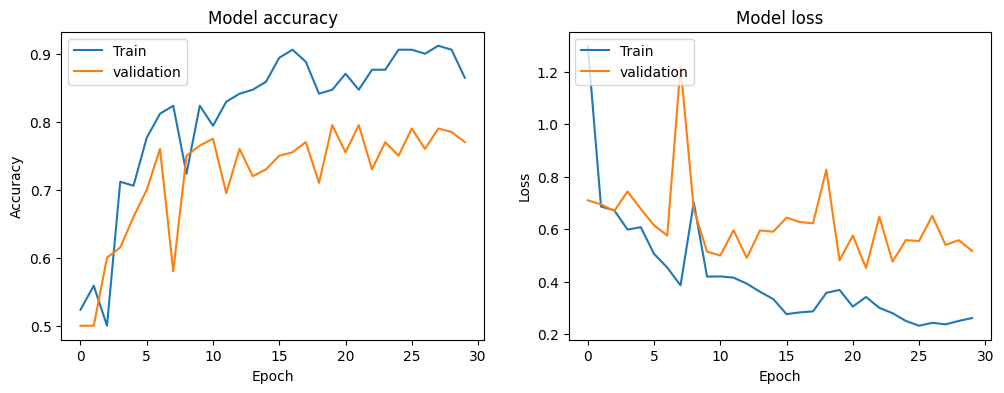

In [14]:
cwd = os.getcwd()
dir_train_rubens = "dataset/validation/rubens"
dir_train_picasso= "dataset/validation/picasso"
dir_validation_rubens = "dataset/test/rubens"
dir_validation_picasso= "dataset/test/picasso"
file_train_rubens = os.listdir(dir_train_rubens)
file_validation_rubens = os.listdir(dir_validation_rubens)
file_train_picasso = os.listdir(dir_train_picasso)
file_validation_picasso = os.listdir(dir_validation_picasso)

train_rubens =[Image.open(os.path.join(dir_train_rubens, file)) for file in file_train_rubens]
train_picasso =[Image.open(os.path.join(dir_train_picasso, file)) for file in file_train_picasso]
validation_rubens = [Image.open(os.path.join(dir_validation_rubens, file)) for file in file_validation_rubens]
validation_picasso = [Image.open(os.path.join(dir_validation_picasso, file)) for file in file_validation_picasso]

train_set, train_labels = mix(train_rubens, train_picasso)
validation_set, validation_labels = mix(validation_rubens, validation_picasso)

train_set = train_set.reshape(len(train_set), 412, 550, 3)
validation_set = validation_set.reshape(len(validation_set), 412, 550, 3)

callbacks = [keras.callbacks.ModelCheckpoint(filepath="convnet_with_augmentation.keras")]

history = model.fit(train_set, train_labels, validation_data=(validation_set, validation_labels), epochs=30, batch_size=60, callbacks=callbacks)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')

plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler

model = keras.models.load_model('convnet_with_augmentation.keras')

layer_output = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_output.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_output)

img_path = Image.open("dataset/test/picasso/1468.jpg")
img_path = np.reshape(img_path, (412, 550, 3))
img_path = np.expand_dims(img_path, axis=0)

activations = activation_model.predict(img_path)
print(model.predict(img_path))

images_per_row = 4
for layer_name, layer_activations in zip(layer_names, activations):
    n_features = layer_activations.shape[-1]
    height = layer_activations.shape[2]
    width = layer_activations.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((width + 1) * n_cols - 1, images_per_row * (height + 1) - 1))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            chanal_index = col * images_per_row + row
            channel_img = layer_activations[0, :, :, chanal_index].copy()
            
            if channel_img.sum() != 0:
                channel_img -= channel_img.mean()
                channel_img /= channel_img.std()
                channel_img *= 64
                channel_img += 128

            channel_img = np.clip(channel_img, 0, 255).astype(np.uint8)

            display_grid[
                col * (width + 1) : (col + 1) * width + col, 
                row * (height + 1) : (row + 1) * height + row
            ] = channel_img

    scale_width = 1.0 / width
    scale_height = 1.0 / height
    # plt.figure(figsize=(scale_height * display_grid.shape[1],scale_width * display_grid.shape[0]))
    # plt.title(layer_name)
    # plt.grid(False)
    # plt.imshow(display_grid, aspect='auto', cmap='viridis')


1/1 [==============================] - 0s 141ms/step
[[2.2979176e-10 1.0000000e+00]]


In [16]:
cwd = os.getcwd()
dir_test_rubens = "dataset/test/rubens"
dir_test_picasso= "dataset/test/picasso"
file_test_rubens = os.listdir(dir_test_rubens)
file_test_picasso = os.listdir(dir_test_picasso)

test_rubens = [Image.open(os.path.join(dir_test_rubens, file)) for file in file_validation_rubens]
test_picasso = [Image.open(os.path.join(dir_test_picasso, file)) for file in file_test_picasso]

test_set, test_labels = mix(test_rubens, test_picasso)

test_set = test_set.reshape(len(test_set), 412, 550, 3)

test_model = keras.models.load_model('convnet_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_set, test_labels)
print('Test loss:', test_loss)

7/7 [==============================] - 3s 338ms/step - loss: 0.5173 - accuracy: 0.7700
Test loss: 0.51734459400177
